
## Pitch Modeling


Goals for a new approach to pitch modeling:

- Improve the target variable. Most stuff models use target metrics like context-neutral re24/re288 run values, context-specific run values like delta_run_exp, or called/swinging strike rate (CSW%). My approach will use expected run value as seen in expected wOBA, which uses exit velocity and launch angle to predict wOBA. I won't be using wOBA as a base metric due to reasons I've discussed [here](https://sam-walsh.github.io/posts/double-plays/) and [here](https://sam-walsh.github.io/posts/fixing-xwoba/). Instead I will be predicting  run values for balls in play based on exit velocity, launch angle, and batter handedness normalized spray angle bins to reduce the noise of the target metric, while still taking into account context-specific outcomes like double plays and sacrifice flies.

- Improve location modeling. Scott Powers, former Dodgers Analyst, and Professor of Sports Analytics and his student Vicente Iglesias recently gave a presentation at Saberseminar about improving location modeling using bayesian hierarchical models. More about that [here](https://github.com/saberpowers/predictive-pitch-score/blob/main/documentation/2023-08-12_saberseminar/slides.pdf). I will be taking a similar approach which will help improve location modeling, especially in small sample sizes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
import xgboost as xgb
import joblib

In [2]:
# load in data with predicted run values
df = pd.read_csv('statcast_data/df_all_spin.csv')

In [3]:
## Calculate vertical approach angle and horizontal approach angle (degrees) for each pitch
df['vaa'] = np.arctan((df['plate_z'] - df['release_pos_z']) / (df['release_pos_y'])) * (180 / np.pi)
df['haa'] = np.arctan((df['plate_x'] - df['release_pos_x']) / (df['release_pos_y'])) * (180 / np.pi)

df['axis_deviation_adj'] = np.where(df['p_throws']=='L', df['diff_measured_inferred'].mul(-1), df['diff_measured_inferred'])

In [4]:
df.loc[df['p_throws']=='R'].groupby('pitch_type')[['vaa', 'haa']].mean()

,vaa,haa
pitch_type,,
CH,-4.156392,1.638207
CS,-4.237966,1.667911
CU,-4.345295,1.946825
EP,-3.541607,1.428788
FA,-3.573859,1.785931
FC,-3.759505,2.317189
FF,-3.256688,1.919538
FO,-5.085853,1.909982
FS,-4.433071,1.591270


In [5]:
df.pitch_type.unique()

array(['FF', 'SL', 'SI', 'FC', 'CU', 'CH', 'KC', 'CS', 'FS', 'ST', 'SV',
       'EP', 'FA', nan, 'KN', 'PO', 'SC', 'FO'], dtype=object)

Group pitch types

In [6]:
fastballs = ['FF', 'SI', 'FC']
non_fastballs = ['CH', 'FS', 'FO', 'KC', 'CU', 'SL', 'ST', 'SV', 'CS', 'SC']

Train on 2020-2022 data, use 2023 as holdout set

In [7]:
df_fastballs = df.loc[(df['pitch_type'].isin(fastballs)) & (df['game_year'].isin([2020, 2021, 2022]))]
df_fastballs_holdout = df.loc[(df['pitch_type'].isin(fastballs)) & (df['game_year']==2023)]

In [8]:
df_fastballs.head()

,Unnamed: 0.1,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,predicted_run_value,player_id,api_pitch_type,active_spin_formatted,hawkeye_measured,movement_inferred,diff_measured_inferred,vaa,haa,axis_deviation_adj
0,0,2875.0,FF,2020-09-27,91.6,2.31,6.19,"Hand, Brad",605137,543272,...,0.015513,543272.0,FF,89.0,129.2,139.2,-10.0,-3.002928,-2.721848,10.0
6,6,3604.0,FF,2020-09-27,92.8,2.39,6.27,"Hand, Brad",663647,543272,...,-0.240455,543272.0,FF,89.0,129.2,139.2,-10.0,-3.475779,-2.956457,10.0
10,10,2843.0,SI,2020-09-27,96.7,-2.20,5.92,"Cederlind, Blake",596019,664977,...,-0.192297,NaN,NaN,NaN,NaN,NaN,NaN,-4.351309,2.456165,NaN
11,11,2951.0,SI,2020-09-27,97.1,-2.20,5.99,"Cederlind, Blake",596019,664977,...,-0.060000,NaN,NaN,NaN,NaN,NaN,NaN,-3.498537,2.966262,NaN
12,12,3160.0,SI,2020-09-27,97.3,-2.34,5.94,"Cederlind, Blake",596019,664977,...,0.060000,NaN,NaN,NaN,NaN,NaN,NaN,-3.579655,3.569029,NaN


In [9]:
fastball_features = [
    'release_speed', 'az', 'ax', 'active_spin_formatted',
    'plate_x', 'plate_z', 'axis_deviation_adj', 'release_pos_x',
    'release_pos_y', 'release_pos_z'
]
target = 'predicted_run_value'

In [10]:
df_fastballs[fastball_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 961780 entries, 0 to 1717441
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   release_speed          961752 non-null  float64
 1   az                     961766 non-null  float64
 2   ax                     961766 non-null  float64
 3   active_spin_formatted  941022 non-null  float64
 4   plate_x                961766 non-null  float64
 5   plate_z                961766 non-null  float64
 6   axis_deviation_adj     941022 non-null  float64
 7   vaa                    961622 non-null  float64
 8   haa                    961622 non-null  float64
dtypes: float64(9)
memory usage: 73.4 MB


In [11]:
df_fastballs[target].info()

<class 'pandas.core.series.Series'>
Index: 961780 entries, 0 to 1717441
Series name: predicted_run_value
Non-Null Count   Dtype  
--------------   -----  
961780 non-null  float64
dtypes: float64(1)
memory usage: 14.7 MB


In [12]:
df_fastballs = df_fastballs.dropna(subset=fastball_features)
df_fastballs = df_fastballs.dropna(subset=[target])

df_fastballs_holdout = df_fastballs_holdout.dropna(subset=fastball_features)
df_fastballs_holdout = df_fastballs_holdout.dropna(subset=[target])

In [13]:
df_fastballs.head()

,Unnamed: 0.1,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,predicted_run_value,player_id,api_pitch_type,active_spin_formatted,hawkeye_measured,movement_inferred,diff_measured_inferred,vaa,haa,axis_deviation_adj
0,0,2875.0,FF,2020-09-27,91.6,2.31,6.19,"Hand, Brad",605137,543272,...,0.015513,543272.0,FF,89.0,129.2,139.2,-10.0,-3.002928,-2.721848,10.0
6,6,3604.0,FF,2020-09-27,92.8,2.39,6.27,"Hand, Brad",663647,543272,...,-0.240455,543272.0,FF,89.0,129.2,139.2,-10.0,-3.475779,-2.956457,10.0
23,23,4283.0,FF,2020-09-27,91.3,2.59,5.99,"Hand, Brad",624428,543272,...,0.243738,543272.0,FF,89.0,129.2,139.2,-10.0,-4.009259,-3.386027,10.0
24,24,4455.0,FF,2020-09-27,92.5,2.43,6.14,"Hand, Brad",624428,543272,...,0.060000,543272.0,FF,89.0,129.2,139.2,-10.0,-3.643167,-3.466656,10.0
25,25,4472.0,FF,2020-09-27,90.5,2.52,6.02,"Hand, Brad",624428,543272,...,-0.060000,543272.0,FF,89.0,129.2,139.2,-10.0,-4.321128,-3.717588,10.0


In [14]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=10)

# Get the indices for the training and validation sets
train_idx, val_idx = next(gss.split(df_fastballs, groups=df_fastballs['pitcher']))

# Create the training and validation sets
train = df_fastballs.iloc[train_idx]
val = df_fastballs.iloc[val_idx]

In [15]:
# Define the objective function for Optuna
def objective(trial: Trial) -> float:
    params = {
        'device': 'cuda',  # Use GPU acceleration
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(train[fastball_features], train[target])

    val_preds = model.predict(val[fastball_features])
    val_error = np.sqrt(((val_preds - val[target]) ** 2).mean())

    return val_error

# Run the Optuna optimization
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Print the best parameters
print(study.best_params)


[I 2023-09-18 02:10:25,230] A new study created in memory with name: no-name-cc60e886-6c42-4794-ad1c-0df9d81e6dd1
c:\Users\wampl\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:10:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2023-09-18 02:10:44,558] Trial 0 finished with value: 0.16695289569319566 and parameters: {'n_estimators': 812, 'max_depth': 10, 'learning_rate': 0.07346740023932911, 'subsample': 0.7993292420985183, 'colsample_bytree': 

{'n_estimators': 1636, 'max_depth': 5, 'learning_rate': 0.010669539286632005, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007}


In [16]:
params = study.best_params
params['device'] = 'cuda'
xgb_fastball = xgb.XGBRegressor(**params)
xgb_fastball.fit(df_fastballs[fastball_features], df_fastballs[target])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7200762468698007, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.010669539286632005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1636, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
xgb_fastball.save_model('models/xgb_fastball.json')

In [18]:
xgb_fastball = xgb.XGBRegressor()
xgb_fastball.load_model('models/xgb_fastball.json')

In [19]:
df_fastballs_holdout['xgb_preds'] = xgb_fastball.predict(df_fastballs_holdout[fastball_features])

In [20]:
test_preds = df_fastballs_holdout.groupby(['player_name', 'pitch_type'], as_index=False)[['predicted_run_value', 'xgb_preds', 'release_speed']] \
    .agg({'predicted_run_value':'mean', 'xgb_preds':'mean', 'release_speed':'count'}) \
    .reset_index() \
    .rename(columns={'release_speed':'count'})

Generate percentile rankings for fastballs

In [21]:
test_preds['predicted_run_value_percentile'] = (1 - test_preds['predicted_run_value'].rank(pct=True).round(3)).mul(100)
test_preds['stuff_percentile'] = (1 - test_preds['xgb_preds'].rank(pct=True).round(3)).mul(100)
test_preds.query('count > 100').sort_values('xgb_preds', ascending=True).head(50)

,index,player_name,pitch_type,predicted_run_value,xgb_preds,count,predicted_run_value_percentile,stuff_percentile
979,979,"Rasmussen, Drew",FF,-0.005980,-0.016148,199,76.5,99.7
446,446,"Graterol, Brusdar",SI,-0.018734,-0.014819,383,93.4,99.6
83,83,"Bautista, Félix",FF,-0.018652,-0.014159,696,93.3,99.6
1136,1136,"Stewart, Brock",FF,-0.016598,-0.013627,151,91.2,99.3
978,978,"Rasmussen, Drew",FC,-0.017829,-0.013578,242,92.7,99.2
1237,1237,"Vesia, Alex",FF,-0.008847,-0.013484,528,81.5,99.1
814,814,"Minter, A.J.",FC,-0.005658,-0.013038,377,75.9,98.8
493,493,"Helsley, Ryan",FF,-0.017654,-0.012920,294,92.6,98.8
1148,1148,"Strider, Spencer",FF,-0.004205,-0.012828,1653,71.8,98.7
337,337,"Estrada, Jeremiah",FF,0.022765,-0.012333,199,15.8,98.6


In [22]:
test_preds.loc[test_preds['player_name']=='Harrison, Kyle']

,index,player_name,pitch_type,predicted_run_value,xgb_preds,count,predicted_run_value_percentile,stuff_percentile
477,477,"Harrison, Kyle",FF,-0.000525,0.003776,267,62.0,46.2


[02:18:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[02:18:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


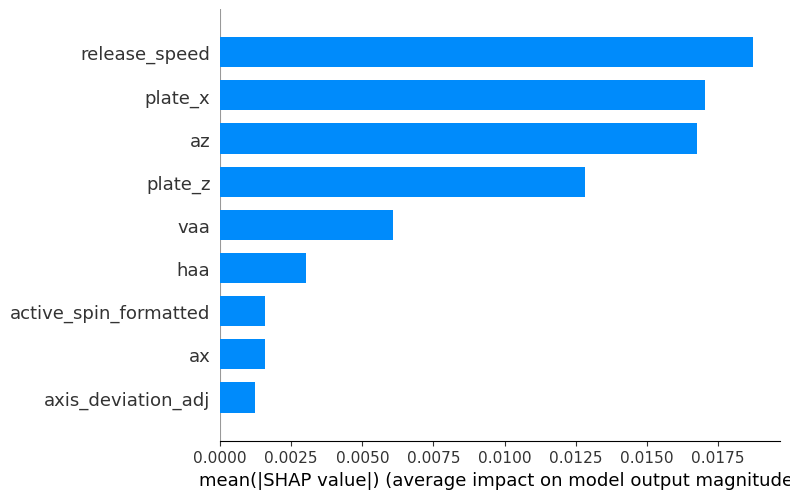

In [23]:
import shap

def plot_shap_values(df, model, features, pitch_type, pitcher=None):
    # Filter the data for the specified pitch type
    df_filtered = df[df['pitch_type'] == pitch_type]
    if pitcher:
        df_filtered = df_filtered[df_filtered['pitcher'] == pitcher]
    # Create the explainer
    explainer = shap.Explainer(model)

    # Calculate the shap values
    shap_values = explainer.shap_values(df_filtered[features])

    # Plot the shap values
    shap.summary_plot(shap_values, df_filtered[features], plot_type="bar")

plot_shap_values(df_fastballs, xgb_fastball, fastball_features, 'SI', 643511)

Top 50 four-seam fastballs

In [24]:
test_preds.loc[test_preds['pitch_type']=='FF', ['player_name', 'pitch_type', 'stuff_percentile', 'count']].query('count > 25').sort_values('stuff_percentile', ascending=False).head(50)

,player_name,pitch_type,stuff_percentile,count
979,"Rasmussen, Drew",FF,99.7,199
83,"Bautista, Félix",FF,99.6,696
1136,"Stewart, Brock",FF,99.3,151
1237,"Vesia, Alex",FF,99.1,528
163,"Burdi, Nick",FF,99.0,41
493,"Helsley, Ryan",FF,98.8,294
1148,"Strider, Spencer",FF,98.7,1653
337,"Estrada, Jeremiah",FF,98.6,199
1080,"Sewald, Paul",FF,98.3,569
1067,"Scott, Tanner",FF,97.7,526


Top 20 cutters

In [25]:
test_preds.loc[test_preds['pitch_type']=='FC', ['player_name', 'pitch_type', 'stuff_percentile', 'count']].query('count > 100').sort_values('stuff_percentile', ascending=False).head(20)

,player_name,pitch_type,stuff_percentile,count
978,"Rasmussen, Drew",FC,99.2,242
814,"Minter, A.J.",FC,98.8,377
1265,"Walter, Brandon",FC,97.5,114
221,"Clase, Emmanuel",FC,97.4,709
568,"Jansen, Kenley",FC,97.4,568
347,"Faucher, Calvin",FC,96.7,158
1293,"Wesneski, Hayden",FC,95.7,141
416,"Gibaut, Ian",FC,95.4,294
453,"Gray, Sonny",FC,95.1,355
1151,"Stroman, Marcus",FC,94.8,202


Top 20 sinkers

In [26]:
test_preds.loc[test_preds['pitch_type']=='SI', ['player_name', 'pitch_type', 'stuff_percentile', 'count']].query('count > 100').sort_values('stuff_percentile', ascending=False).head(50)

,player_name,pitch_type,stuff_percentile,count
446,"Graterol, Brusdar",SI,99.6,383
205,"Chapman, Aroldis",SI,98.5,143
1016,"Rogers, Tyler",SI,98.4,523
465,"Hader, Josh",SI,98.2,686
767,"May, Dustin",SI,98.2,245
1021,"Romero, JoJo",SI,98.0,184
706,"Loáisiga, Jonathan",SI,97.9,165
18,"Alcantara, Sandy",SI,97.9,790
1204,"Topa, Justin",SI,97.6,422
28,"Almonte, Yency",SI,97.3,212


#### Breaking ball / off-speed feature engineering
Calculating some fastball-relative features 

In [27]:
from feature_engineering import compute_fastball_relative_features
df = compute_fastball_relative_features(df)

In [49]:
non_fastball_features = [
    'release_speed', 'release_spin_rate', 'az', 'ax', 'plate_x', 'plate_z',
    'axis_deviation_adj', 'velo_delta', 'spin_axis_delta',
    'vert_delta', 'horz_delta', 'release_pos_x', 'release_pos_y',
    'release_pos_z'
]
target = 'predicted_run_value'

In [50]:
df_non_fastballs = df.loc[df['pitch_type'].isin(non_fastballs) & (df['game_year'].isin([2020, 2021, 2022]))]
df_non_fastballs_holdout = df.loc[df['pitch_type'].isin(non_fastballs) & (df['game_year']==2023)]

In [51]:
df_non_fastballs[non_fastball_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 727319 entries, 1 to 1717442
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   release_speed       727286 non-null  float64
 1   release_spin_rate   723866 non-null  float64
 2   az                  727293 non-null  float64
 3   ax                  727293 non-null  float64
 4   plate_x             727293 non-null  float64
 5   plate_z             727293 non-null  float64
 6   axis_deviation_adj  706657 non-null  float64
 7   velo_delta          713897 non-null  float64
 8   spin_axis_delta     706657 non-null  float64
 9   vert_delta          713903 non-null  float64
 10  horz_delta          713903 non-null  float64
 11  vaa                 727227 non-null  float64
 12  haa                 727227 non-null  float64
dtypes: float64(13)
memory usage: 77.7 MB


In [52]:
df_non_fastballs = df_non_fastballs.dropna(subset=non_fastball_features)
df_non_fastballs = df_non_fastballs.dropna(subset=[target])

df_non_fastballs_holdout = df_non_fastballs_holdout.dropna(subset=non_fastball_features)
df_non_fastballs_holdout = df_non_fastballs_holdout.dropna(subset=[target])

In [53]:
# Create a GroupShuffleSplit to keep pitchers in the same training or validation set
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=10)

# Get the indices for the training and validation sets
train_idx, val_idx = next(gss.split(df_non_fastballs, groups=df_non_fastballs['pitcher']))

# Create the training and validation sets
train = df_non_fastballs.iloc[train_idx]
val = df_non_fastballs.iloc[val_idx]

Train and tune non-fastball model

In [54]:
# Define the objective function for Optuna
def objective(trial: Trial) -> float:
    params = {
        'device': 'cuda',  # Use GPU acceleration
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(train[non_fastball_features], train[target])

    val_preds = model.predict(val[non_fastball_features])
    val_error = np.sqrt(((val_preds - val[target]) ** 2).mean())

    return val_error

# Run the Optuna optimization
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Print the best parameters
params = study.best_params
params['device'] = 'cuda'

xgb_non_fastball = xgb.XGBRegressor(**params)
xgb_non_fastball.fit(df_non_fastballs[non_fastball_features], df_non_fastballs[target])


[I 2023-09-18 02:43:16,149] A new study created in memory with name: no-name-15141edd-118e-41b2-960e-9c8c7a0e3d86


[I 2023-09-18 02:43:34,295] Trial 0 finished with value: 0.16362830445581197 and parameters: {'n_estimators': 812, 'max_depth': 10, 'learning_rate': 0.07346740023932911, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 0.16362830445581197.
[I 2023-09-18 02:43:36,730] Trial 1 finished with value: 0.15985592480557642 and parameters: {'n_estimators': 396, 'max_depth': 3, 'learning_rate': 0.08675143843171859, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 0.15985592480557642.
[I 2023-09-18 02:43:40,141] Trial 2 finished with value: 0.161010946059493 and parameters: {'n_estimators': 139, 'max_depth': 10, 'learning_rate': 0.08341182143924175, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 0.15985592480557642.
[I 2023-09-18 02:43:43,358] Trial 3 finished with value: 0.1597972685174598 and parameters: {'n_estimators': 448, 'max_depth

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5849728790048966, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.011953982690033742, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1153, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [55]:
xgb_non_fastball.save_model('models/xgb_non_fastball.json')

In [56]:
xgb_non_fastball = xgb.XGBRegressor()
xgb_non_fastball.load_model('models/xgb_non_fastball.json')

In [57]:
df_non_fastballs_holdout['xgb_preds'] = xgb_non_fastball.predict(df_non_fastballs_holdout[non_fastball_features])

In [58]:
test_preds_non_fb = df_non_fastballs_holdout.groupby(['player_name', 'pitch_type'], as_index=False)[['predicted_run_value', 'xgb_preds', 'release_speed']] \
    .agg({'predicted_run_value':'mean', 'xgb_preds':'mean', 'release_speed':'count'}) \
    .reset_index() \
    .rename(columns={'release_speed':'count'})

In [59]:
test_preds_non_fb['predicted_run_value_percentile'] = (1 - test_preds_non_fb['predicted_run_value'].rank(pct=True).round(3)).mul(100)
test_preds_non_fb['stuff_percentile'] = (1 - test_preds_non_fb['xgb_preds'].rank(pct=True).round(3)).mul(100)
test_preds_non_fb.query('count > 100').sort_values('xgb_preds', ascending=False).head(50)

,index,player_name,pitch_type,predicted_run_value,xgb_preds,count,predicted_run_value_percentile,stuff_percentile
1010,1010,"Muller, Kyle",CH,0.031308,0.035856,109,11.3,0.3
754,754,"Kopech, Michael",CH,0.017547,0.028802,179,24.8,0.6
1076,1076,"Oviedo, Johan",CH,0.012916,0.021467,122,31.3,2.3
367,367,"Dunning, Dane",CU,0.020770,0.019718,121,20.1,3.1
61,61,"Baker, Bryan",CH,0.009197,0.018405,113,37.8,3.6
124,124,"Bielak, Brandon",CU,0.020004,0.018113,155,21.4,3.7
1046,1046,"Norris, Daniel",CH,0.016925,0.017650,110,25.7,4.1
1304,1304,"Singer, Brady",CH,0.030707,0.017336,159,11.4,4.2
85,85,"Bassitt, Chris",FS,0.040181,0.016175,102,7.9,5.1
1142,1142,"Pérez, Eury",CH,0.001396,0.015626,146,53.5,5.7


In [60]:
test_preds_non_fb.loc[test_preds_non_fb['player_name']=='Harrison, Kyle']

,index,player_name,pitch_type,predicted_run_value,xgb_preds,count,predicted_run_value_percentile,stuff_percentile
566,566,"Harrison, Kyle",CH,0.020517,-0.001002,40,20.6,54.5
567,567,"Harrison, Kyle",SV,0.018776,0.003418,106,22.8,29.9


[02:50:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[02:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


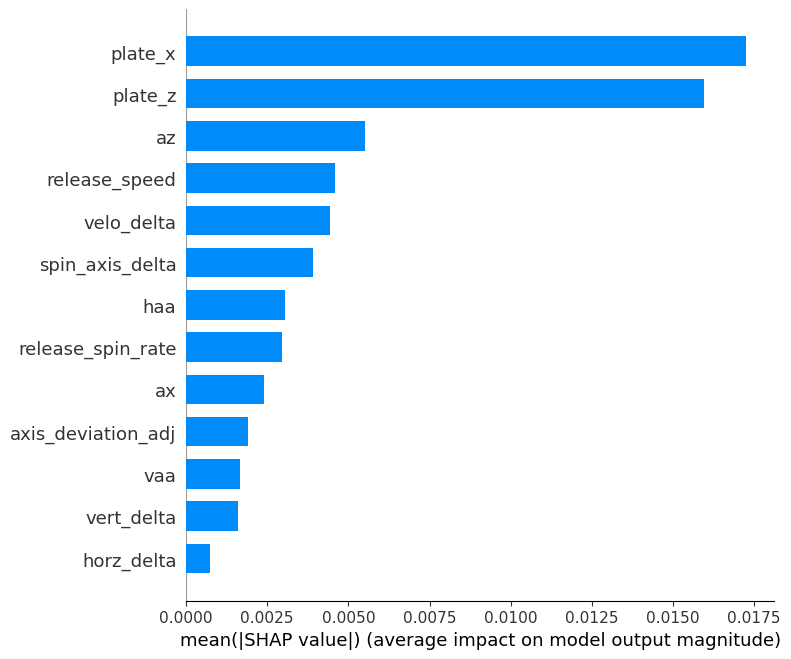

In [61]:
plot_shap_values(df_non_fastballs, xgb_non_fastball, non_fastball_features, 'SL', 643511)

Top changeups

In [62]:
test_preds_non_fb.loc[test_preds_non_fb['pitch_type']=='CH', ['player_name', 'pitch_type', 'stuff_percentile', 'count']].query('count > 100').sort_values('stuff_percentile', ascending=False).head(50)

,player_name,pitch_type,stuff_percentile,count
1551,"Williams, Devin",CH,99.8,507
163,"Brazoban, Huascar",CH,98.9,271
27,"Alcantara, Sandy",CH,98.5,742
1098,"Pepiot, Ryan",CH,98.5,139
1106,"Peralta, Wandy",CH,98.2,390
986,"Montero, Rafael",CH,98.1,249
716,"Kelly, Merrill",CH,97.6,588
1327,"Snell, Blake",CH,95.5,540
960,"Miller, Bobby",CH,93.1,264
457,"Gallen, Zac",CH,92.6,408


Top curveballs

In [63]:
test_preds_non_fb.loc[test_preds_non_fb['pitch_type']=='CU', ['player_name', 'pitch_type', 'stuff_percentile', 'count']].query('count > 100').sort_values('stuff_percentile', ascending=False).head(50)

,player_name,pitch_type,stuff_percentile,count
369,"Duran, Jhoan",CU,94.3,259
598,"Herget, Jimmy",CU,93.3,156
783,"Lange, Alex",CU,92.7,618
684,"Johnson, Pierce",CU,88.9,591
734,"Kikuchi, Yusei",CU,88.6,472
923,"McClanahan, Shane",CU,88.1,309
1230,"Ryu, Hyun Jin",CU,87.7,108
961,"Miller, Bobby",CU,86.8,317
473,"García, Yimi",CU,84.5,333
910,"May, Dustin",CU,84.2,148


Top splitters

In [64]:
test_preds_non_fb.loc[test_preds_non_fb['pitch_type']=='FS', ['player_name', 'pitch_type', 'stuff_percentile', 'count']].query('count > 100').sort_values('stuff_percentile', ascending=False).head(50)

,player_name,pitch_type,stuff_percentile,count
572,"Harvey, Hunter",FS,99.6,163
370,"Duran, Jhoan",FS,96.6,258
416,"Finnegan, Kyle",FS,96.5,259
1576,"Winn, Keaton",FS,96.1,286
563,"Harris, Hobie",FS,92.1,175
385,"Eovaldi, Nathan",FS,91.0,536
870,"Maeda, Kenta",FS,90.4,489
93,"Bautista, Félix",FS,90.3,242
101,"Bednar, David",FS,86.2,167
811,"Littell, Zack",FS,84.3,219


In [70]:
test_preds_non_fb.loc[test_preds_non_fb['pitch_type']=='SL', ['player_name', 'pitch_type', 'stuff_percentile', 'count']].query('count > 50').sort_values('stuff_percentile', ascending=False).head(50)


,player_name,pitch_type,stuff_percentile,count
1617,"deGrom, Jacob",SL,99.9,167
1251,"Santos, Gregory",SL,99.7,551
1303,"Sims, Lucas",SL,99.4,500
1131,"Pressly, Ryan",SL,99.3,379
962,"Miller, Bobby",SL,99.3,299
236,"Chapman, Aroldis",SL,99.1,267
1256,"Sborz, Josh",SL,98.9,307
587,"Helsley, Ryan",SL,98.6,175
1160,"Ragans, Cole",SL,98.0,146
481,"Garrett, Reed",SL,97.8,57


In [66]:
test_preds_non_fb.loc[test_preds_non_fb['player_name']=='Rogers, Tyler']

,index,player_name,pitch_type,predicted_run_value,xgb_preds,count,predicted_run_value_percentile,stuff_percentile
1208,1208,"Rogers, Tyler",SL,-0.01633,-0.008112,497,87.4,86.8


In [67]:
test_preds_full= pd.concat([df_fastballs_holdout, df_non_fastballs_holdout])
len(test_preds_full)

651980

In [68]:
df_non_fastballs_holdout.loc[df_non_fastballs_holdout['player_name']=='Rogers, Tyler'].groupby('pitch_type')['xgb_preds'].mean()

pitch_type
SL   -0.008112
Name: xgb_preds, dtype: float32

In [69]:
test_preds_full.to_csv('model_predictions.csv')